# Explore eo-learn package 

In [1]:
# ML libs
import pandas as pd
import numpy as np
from aenum import MultiValueEnum
import geopandas as gpd

import datetime
# File manipulation
import os
from urllib.request import urlopen
import json
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import rasterio
import rasterio.plot as rplt

# Graphic
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import plotly.express as px
from sentinelhub import BBox, CRS
import shapely

# Environment variables
datasets_dir = os.environ.get('DATA_DIR_LOCAL')

In [2]:
one_view_dir = "RPG/S2A_MSIL2A_20240412T105621_N0510_R094_T30TXP_20240412T165247.SAFE"
one_view_path = os.path.join(datasets_dir,one_view_dir)

# Accessing the bounding-box info of the satellite image

In [3]:
one_view_path = os.path.join(one_view_path,os.listdir(one_view_path)[0])

In [4]:
os.listdir(one_view_path)

['DATASTRIP',
 'manifest.safe',
 'S2A_MSIL2A_20240412T105621_N0510_R094_T30TXP_20240412T165247-ql.jpg',
 'rep_info',
 'MTD_MSIL2A.xml:Zone.Identifier',
 'INSPIRE.xml:Zone.Identifier',
 'HTML',
 'S2A_MSIL2A_20240412T105621_N0510_R094_T30TXP_20240412T165247-ql.jpg:Zone.Identifier',
 'MTD_MSIL2A.xml',
 'GRANULE',
 'INSPIRE.xml',
 'manifest.safe:Zone.Identifier']

In [5]:
MTD_MSIL2A_file = os.path.join(one_view_path, 'MTD_MSIL2A.xml')
with open(MTD_MSIL2A_file) as fp:
    MTD_MSIL2A_soup = BeautifulSoup(fp,'xml')

In [6]:
MTD_MSIL2A_coord_list = MTD_MSIL2A_soup.find('EXT_POS_LIST').text.split()

In [7]:
coord_array = np.array(MTD_MSIL2A_coord_list).reshape(int(len(MTD_MSIL2A_coord_list)/2), 2)

## Create geopandas dataframe with image bounds

In [8]:
#TODO compute local_CRS
local_CRS = '32630'

In [9]:
img_gdf = gpd.GeoDataFrame({"id": [0], "geometry": [shapely.geometry.Polygon([[lon, lat] for lat, lon in coord_array])]}, crs="EPSG:4326").to_crs(local_CRS)
img_gdf['geometry']

0    POLYGON ((600000.000 4900020.000, 709800.000 4...
Name: geometry, dtype: geometry

# Create bbox on a zone

In [10]:
from shapely.geometry import Polygon

from tqdm.auto import tqdm
import geopandas as gpd

from sentinelhub import DataCollection, UtmZoneSplitter

# Imports from eo-learn and sentinelhub
from eolearn.core import (
    EOExecutor,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    LoadTask,
    MergeFeatureTask,
    OverwritePermission,
    SaveTask,
    linearly_connect_tasks,
)
from eolearn.features import NormalizedDifferenceIndexTask, SimpleFilterTask
from eolearn.features.extra.interpolation import LinearInterpolationTask
from eolearn.geometry import ErosionTask, VectorToRasterTask
from eolearn.io import ExportToTiffTask, SentinelHubInputTask, VectorImportTask
from eolearn.ml_tools import FractionSamplingTask

In [20]:
source_data = gpd.read_file(os.path.join(DATA_FOLDER, "contour-du-pays-basque.geojson"))

In [24]:
source_data.geometry.values[0].bounds

(-1.792350952083531, 42.95072315985167, -0.745872490046169, 43.547254988966124)

Dimension of the area is 85431 x 65625 m2


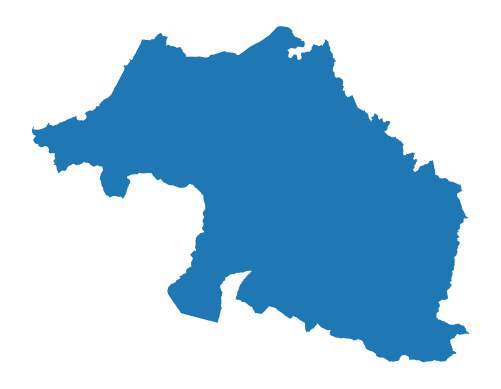

In [11]:
# Folder where data for running the notebook is stored
DATA_FOLDER = os.path.join(datasets_dir, "RPG/PaysBasque")
# Locations for collected data and intermediate results
EOPATCH_FOLDER = os.path.join(".", "eopatches")
EOPATCH_SAMPLES_FOLDER = os.path.join(".", "eopatches_sampled")
RESULTS_FOLDER = os.path.join(".", "results")
for folder in (EOPATCH_FOLDER, EOPATCH_SAMPLES_FOLDER, RESULTS_FOLDER):
    os.makedirs(folder, exist_ok=True)
#TODO compute regional crs
local_CRS = '32630'
# Load geojson file
zone_covered = gpd.read_file(os.path.join(DATA_FOLDER, "contour-du-pays-basque.geojson")).to_crs(local_CRS)

# Add 500m buffer to secure sufficient data near border
#zone_covered = zone_covered.buffer(500)

# Get the country's shape in polygon format
zone_covered_shape = zone_covered.geometry.values[0]

# Plot country
zone_covered.plot()
plt.axis("off")

# Print size
zone_covered_width = zone_covered_shape.bounds[2] - zone_covered_shape.bounds[0]
zone_covered_height = zone_covered_shape.bounds[3] - zone_covered_shape.bounds[1]
print(f"Dimension of the area is {zone_covered_width:.0f} x {zone_covered_height:.0f} m2")

In [12]:
zone_covered.bounds

minx          miny           maxx          maxy
0  597840.244268  4.757564e+06  683271.312463  4.823189e+06

In [13]:
# Coordinates format
zone_covered.crs

<Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°W and 0°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Burkina Faso. Côte' Ivoire (Ivory Coast). Faroe Islands - offshore. France. Ghana. Gibraltar. Ireland - offshore Irish Sea. Mali. Mauritania. Morocco. Spain. United Kingdom (UK).
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
resolution = 10 # meters per pixel, used for raster dimension and satellite images
patch_dim = 255 # number of pixel

# Create a splitter to obtain a list of bboxes 
bbox_splitter = UtmZoneSplitter([zone_covered_shape], local_CRS, patch_dim*resolution)
bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]

idxs = [info["index"] for info in info_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]

bbox_gdf = gpd.GeoDataFrame({"index": idxs, "index_x": idxs_x, "index_y": idxs_y}, crs=local_CRS, geometry=geometry)

# Save to shapefile
shapefile_name = "grid_paysbasque_500x500.gpkg"
bbox_gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver="GPKG")

In [15]:
size_surrounding = 1
size_of_selected_area = 2*size_surrounding + 1
# select a 5x5 area (id of center patch)
ID = 27

# Obtain surrounding 5x5 patches
patch_ids = []
for idx, info in enumerate(info_list):
    if abs(info["index_x"] - info_list[ID]["index_x"]) <= size_surrounding and abs(info["index_y"] - info_list[ID]["index_y"]) <= size_surrounding:
        patch_ids.append(idx)

# Check if final size is 5x5
if len(patch_ids) != size_of_selected_area * size_of_selected_area:
    print("Warning! Use a different central patch ID, this one is on the border.")

# Change the order of the patches (useful for plotting)
patch_ids = np.transpose(np.fliplr(np.array(patch_ids).reshape(size_of_selected_area, size_of_selected_area))).ravel()

# Save to shapefile
shapefile_name = "grid_paysbasque_500x500.gpkg"
bbox_gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver="GPKG")

In [16]:
# Display bboxes over country

fig_size = 10
fig, ax = plt.subplots(figsize=(fig_size, fig_size))
ax.set_title(f"Selected {size_of_selected_area}x{size_of_selected_area} tiles from Pays basque", fontsize=0.2*fig_size)
zone_covered.plot(ax=ax, facecolor="w", edgecolor="b", alpha=0.5)
bbox_gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)

for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info["index"], ha="center", va="center")

# Mark bboxes of selected area
bbox_gdf[bbox_gdf.index.isin(patch_ids)].plot(ax=ax, facecolor="g", edgecolor="r", alpha=0.5)

plt.axis("off");

# Plot sentinel image, pays-basque shape, bboxes of selected area

In [17]:
left, bottom, right, top = img_gdf['geometry'][0].bounds

In [18]:

img_path = os.path.join(one_view_path, "GRANULE/L2A_T30TXP_A045994_20240412T110532/QI_DAT/MSK_CLDPRB_20m.jp2")
"\\wsl.localhost\Ubuntu\home\ken\Datasets\Agriculture\RPG\S2A_MSIL2A_20240412T105621_N0510_R094_T30TXP_20240412T165247.SAFE\S2A_MSIL2A_20240412T105621_N0510_R094_T30TXP_20240412T165247.SAFE\GRANULE\L2A_T30TXP_A045994_20240412T110532\QI_DATA\MSK_CLDPRB_20m.jp2"
# Reading the jp2s with rasterio
with rasterio.open(img_path) as f:
    sentinel_img=np.array(f.read())

RasterioIOError: /home/ken/Datasets/Agriculture/RPG/S2A_MSIL2A_20240412T105621_N0510_R094_T30TXP_20240412T165247.SAFE/S2A_MSIL2A_20240412T105621_N0510_R094_T30TXP_20240412T165247.SAFE/GRANULE/L2A_T30TXP_A045994_20240412T110532/QI_DAT/MSK_CLDPRB_20m.jp2: No such file or directory

In [19]:
img_path = os.path.join(one_view_path, 'GRANULE/L2A_T30TXP_A045994_20240412T110532/IMG_DATA/R10m/T30TXP_20240412T105621_TCI_10m.jp2')
GRANULE\L2A_T30TXP_A045994_20240412T110532\QI_DATA\MSK_CLDPRB_20m.jp2
# Reading the jp2s with rasterio
with rasterio.open(img_path) as f:
    sentinel_img=np.array(f.read())

In [19]:
shape = img_gdf['geometry'][0]
fig_size = 10
fig, ax = plt.subplots(figsize=(fig_size, fig_size))
ax.set_title(f"Selected {size_of_selected_area}x{size_of_selected_area} tiles from Pays basque", fontsize=0.2*fig_size)
zone_covered.plot(ax=ax, facecolor="w", edgecolor="b", alpha=0.8)
img_gdf['geometry'].plot(ax=ax, alpha=0.1)
bbox_gdf[bbox_gdf.index.isin(patch_ids)].plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)
plt.imshow(np.moveaxis(sentinel_img,0,2), extent=(left, right, bottom, top), alpha=1);
#rplt.show(sentinel_img, ax=ax, alpha=0.8);

# Create eopatch from sentinel image

In [64]:
def geoimg2eopatch(geo_image, image_shape, crs):
    eopatch = EOPatch(bbox=BBox(bbox=shape.bounds, crs=crs))
    
    # If the image has 3 channels (RGB), add it as a timeless feature
    if geo_image.ndim == 3:
        eopatch.data_timeless['BANDS'] = geo_image
    # If the image is grayscale (2D), add an extra channel dimension
    else:
        eopatch.data_timeless['BANDS'] = geo_image[..., np.newaxis]
    return eopatch

In [67]:
eopatch = geoimg2eopatch(sentinel_img, shape, local_CRS)
eopatch

EOPatch(
  bbox=BBox(((599999.9999996551, 4790220.00005078), (709799.9999992993, 4900020.000051229)), crs=CRS('32630'))
  data_timeless={
    BANDS: numpy.ndarray(shape=(3, 10980, 10980), dtype=uint8)
  }
)

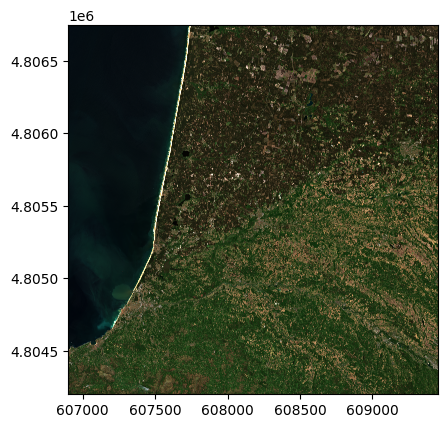

In [68]:
plt.imshow(np.moveaxis(eopatch.data_timeless["BANDS"], 0, 2), extent=(left, right, bottom, top));

# Create sub patches

In [23]:
def create_subpatch(eopatch, small_bbox):
    # Find the pixel indices corresponding to the small_bbox
    height, width = eopatch.data_timeless['BANDS'].shape[-2:]
    
    min_x, min_y = small_bbox.lower_left
    max_x, max_y = small_bbox.upper_right
    patch_min_x, patch_min_y = eopatch.bbox.lower_left
    patch_max_x, patch_max_y = eopatch.bbox.upper_right
    # compute coord of each pixel of eopatch
    x_pxl_coord = np.linspace(patch_min_x, patch_max_x, width)
    y_pxl_coord = np.linspace(patch_min_y, patch_max_y, height)
    x_min_idx = np.searchsorted(x_pxl_coord, min_x)
    x_max_idx = np.searchsorted(x_pxl_coord, max_x)
    y_min_idx = np.searchsorted(y_pxl_coord, min_y)
    y_max_idx = np.searchsorted(y_pxl_coord, max_y)
    # Create a new EOPatch
    new_eopatch = EOPatch(bbox=BBox(bbox=(min_x, min_y, max_x, max_y), crs=local_CRS))
    # Copy data features
    for feature_type, feature_name in eopatch.get_features():
        if feature_type.is_spatial():
            new_eopatch[feature_type][feature_name] = eopatch[feature_type][feature_name][:,height-y_max_idx:height-y_min_idx, x_min_idx:x_max_idx]

    return new_eopatch

In [24]:
small_patch = create_subpatch(eopatch, bbox_list[20])
small_patch

EOPatch(
  bbox=BBox(((606900.0, 4804200.0), (609450.0, 4806750.0)), crs=CRS('32630'))
  data_timeless={
    BANDS: numpy.ndarray(shape=(3, 255, 255), dtype=uint8)
  }
)

In [25]:
gpd.GeoDataFrame(bbox_list[36])
small_box_gdf = gpd.GeoDataFrame({"id": [0], "geometry": [shapely.geometry.Polygon([[lon, lat] for lon, lat in bbox_list[36].get_polygon()])]}, crs=local_CRS)

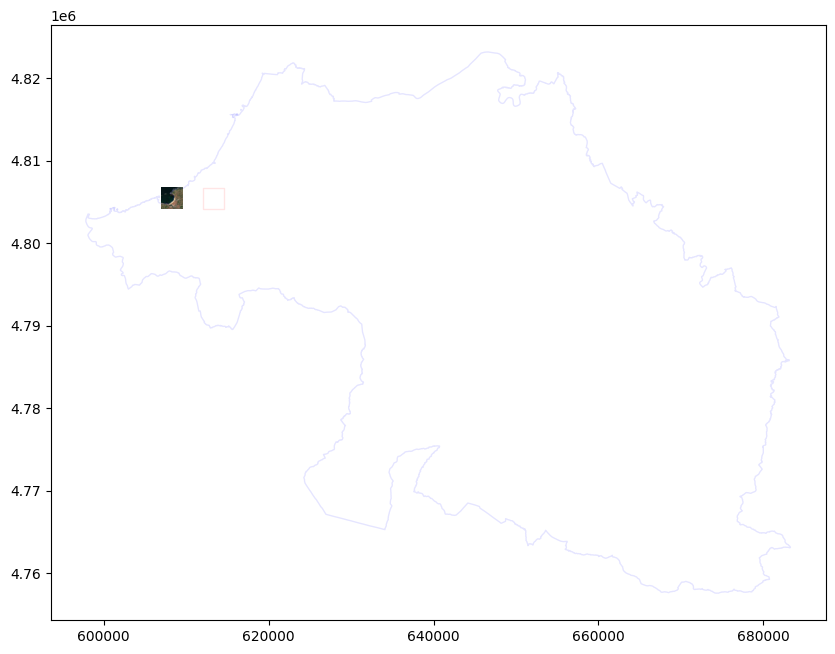

In [26]:
left, bottom, right, top = small_patch.bbox
fig_size = 10
fig, ax = plt.subplots(figsize=(fig_size, fig_size))
zone_covered.plot(ax=ax, facecolor="w", edgecolor="b", alpha=0.1)
ax.imshow(np.moveaxis(small_patch.data_timeless["BANDS"],0,2), extent=(left, right, bottom, top))
small_box_gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.1);
#bbox_gdf[bbox_gdf.index.isin(patch_ids)].plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.1)
   

# Create GroundTruth patches

## Preprocess geojson

In [110]:
paysbasque_geojson_path = os.path.join(DATA_FOLDER, "rpg-2020-registre-parcellaire-graphique.geojson")
# change coordinates system of input data
paysbasque_geojson = gpd.read_file(paysbasque_geojson_path).to_crs(local_CRS)
paysbasque_geojson.dropna(subset=['grp_cultu'], inplace=True)

KeyboardInterrupt: 

In [ ]:
# OneHotEncode grp_cultu column in grp_encoded
encode_dict = {name: i+1 for i, name in enumerate(paysbasque_geojson['grp_cultu'].unique())}
paysbasque_geojson['grp_encoded'] = paysbasque_geojson['grp_cultu'].replace(encode_dict)

In [99]:
# Save preprocessed data
paysbasque_geopd_path = os.path.join(DATA_FOLDER, "rpg-2020-modified.geojson")
paysbasque_geojson.to_file(paysbasque_geopd_path)

In [152]:
# Load preprocessed data
paysbasque_geopd_path = os.path.join(DATA_FOLDER, "rpg-2020-modified.geojson")
paysbasque_geojson = gpd.read_file(paysbasque_geopd_path)

In [136]:
paysbasque_geojson.head()

geo_point_2d geo_shape  \
0  {'lon': -1.0722637006190943, 'lat': 43.2002914...      None   
1  {'lon': -1.257895729374897, 'lat': 43.10041427...      None   
2  {'lon': -1.2612932240073889, 'lat': 43.0908556...      None   
3  {'lon': -1.2608548667251809, 'lat': 43.0906853...      None   
4  {'lon': -1.1076413925015816, 'lat': 43.4611995...      None   

                                            anon_id millesime      bio  \
0  19c955509e22f6c0dcd8a8a5e0a6e27f9797c67ef8e7b247      2020  Oui.000   
1  5c35ec6ae9f796af83283f98770f9bb94f4e1364d855a10b      2020      Non   
2  5c35ec6ae9f796af83283f98770f9bb94f4e1364d855a10b      2020      Non   
3  5c35ec6ae9f796af83283f98770f9bb94f4e1364d855a10b      2020      Non   
4  957b1009c5f9bdedc728e87533aa2c86a5f92a0ac3467bb8      2020      Non   

  code_cultu                                          lbl_cultu  \
0        PTR         Autre prairie temporaire de 5 ans ou moins   
1        SPL  Surface pastorale - ressources fourragères lig...   
2        SPL  Surface pastorale - ressources fourragères lig...   
3        SPL  Surface pastorale - ressources fourragères lig...   
4        MIS                                               Maïs   

                grp_cultu  surface_ha  surf_adm maraichage agroforest  insee  \
0    Prairies temporaires        0.73      0.73          0          0  64150   
1       Estives et landes        1.55      1.23          0          0  64047   
2       Estives et landes        0.83      0.66          0          0  64047   
3       Estives et landes        0.32      0.00          0          0  64047   
4  Maïs grain et ensilage        4.00      4.00          0          0  64161   

       nom  surf_ha           nom_epci        pole_terri  surface_parcelle_m2  \
0    Bunus    665.0  CA du Pays Basque  Iholdi Oztibarre               7300.0   
1  Arnéguy   2115.0  CA du Pays Basque   Garazi Baigorri              15500.0   
2  Arnéguy   2115.0  CA du Pays Basque   Garazi Baigorri               8300.0   
3  Arnéguy   2115.0  CA du Pays Basque   Garazi Baigorri               3200.0   
4     Came   3424.0  CA du Pays Basque   Pays de Bidache              40000.0   

   grp_encoded                                           geometry  
0            1  POLYGON ((656575.594 4784819.582, 656565.588 4...  
1            2  POLYGON ((641793.618 4773532.044, 641818.199 4...  
2            2  POLYGON ((641467.880 4772379.827, 641451.736 4...  
3            2  POLYGON ((641483.176 4772312.901, 641489.718 4...  
4            3  POLYGON ((653073.489 4813933.498, 653126.553 4...

## Create color map for display

In [153]:
grp_cultu_list = list(paysbasque_geojson['grp_encoded'].unique())
cmap = plt.get_cmap('coolwarm', len(grp_cultu_list))

grp_cultu_colormaps = []
grp_cultu_colormaps.append({"name":"No Data", 
                            "id": 0, 
                            "color": "#ff000000"})
for i, cultu in enumerate(grp_cultu_list):
    grp_cultu_colormaps.append({
        "name": cultu,
        "id": i+1,
        "color": cmap(i+1)
    })

pb_cmap = ListedColormap([value['color'] for value in grp_cultu_colormaps], name="pb_cmap")
pb_norm = BoundaryNorm([x - 0.5 for x in range(len(grp_cultu_colormaps))], pb_cmap.N)

## RPG import part of the pipeline/workflow

In [142]:
paysbasque_geojson = os.path.join(DATA_FOLDER, "rpg-2020-registre-parcellaire-graphique.geojson")
vector_feature = FeatureType.VECTOR_TIMELESS, "PB_REFERENCE"

vector_import_task = VectorImportTask(vector_feature, paysbasque_geopd_path)

rasterization_task = VectorToRasterTask(
    vector_feature,
    (FeatureType.MASK_TIMELESS, "pb"),
    values_column="grp_encoded",
    #raster_shape=(FeatureType.MASK, "IS_DATA"),
    raster_resolution=10,
    raster_dtype=np.uint8,
)
# SAVING TO OUTPUT (if needed)
save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

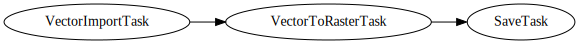

In [143]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
     # add_data, ndvi, ndwi, ndbi, add_sh_validmask, add_valid_count, vector_import_task, rasterization_task, save
    vector_import_task, rasterization_task, save
)
workflow = EOWorkflow(workflow_nodes)

# Let's visualize it
workflow.dependency_graph()

## Launch the workflow

In [144]:
%%time

# Time interval for the SH request
time_interval = ["2019-01-01", "2019-12-31"]

# Define additional parameters of the workflow
input_node = workflow_nodes[0]
save_node = workflow_nodes[-1]
execution_args = []
for idx, bbox in enumerate(bbox_list[patch_ids]):
    execution_args.append(
        {
            input_node: {"bbox": bbox},
            save_node: {"eopatch_folder": f"eopatch_{idx}"},
        }
    )

# Execute the workflow
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=4)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Load and plot patches

In [154]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    ax = axs[i // 3][i % 3]
    im = ax.imshow(eopatch.mask_timeless["pb"].squeeze(), cmap=pb_cmap, norm=pb_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([grp_cultu_dict[key]['id'] for key in grp_cultu_dict.keys()])
cb.ax.set_xticklabels([grp_cultu_dict[key]['name'] for key in grp_cultu_dict.keys()], rotation=45, fontsize=15)
plt.show();

  0%|          | 0/9 [00:00<?, ?it/s]

# Sentinel + ground truth in the same patch

In [93]:
def add_data2subpatch(eopatch, smallpatch):
    # Find the pixel indices corresponding to the small_bbox
    height, width = eopatch.data_timeless['BANDS'].shape[-2:]
    
    min_x, min_y = smallpatch.bbox.lower_left
    max_x, max_y = smallpatch.bbox.upper_right
    patch_min_x, patch_min_y = eopatch.bbox.lower_left
    patch_max_x, patch_max_y = eopatch.bbox.upper_right
    # compute coord of each pixel of eopatch
    x_pxl_coord = np.linspace(patch_min_x, patch_max_x, width)
    y_pxl_coord = np.linspace(patch_min_y, patch_max_y, height)
    x_min_idx = np.searchsorted(x_pxl_coord, min_x)
    x_max_idx = np.searchsorted(x_pxl_coord, max_x)
    y_min_idx = np.searchsorted(y_pxl_coord, min_y)
    y_max_idx = np.searchsorted(y_pxl_coord, max_y)
    # Copy data features
    for feature_type, feature_name in eopatch.get_features():
        if feature_type.is_spatial():
            smallpatch[feature_type][feature_name] = eopatch[feature_type][feature_name][:,height-y_max_idx:height-y_min_idx, x_min_idx:x_max_idx]

    return smallpatch

In [94]:
for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    small_eopatch = EOPatch.load(eopatch_path, lazy_loading=True)
    add_data2subpatch(eopatch, small_eopatch)
    small_eopatch.save(eopatch_path, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

  0%|          | 0/9 [00:00<?, ?it/s]

NameError: name 'eopatch' is not defined

  0%|          | 0/9 [00:00<?, ?it/s]

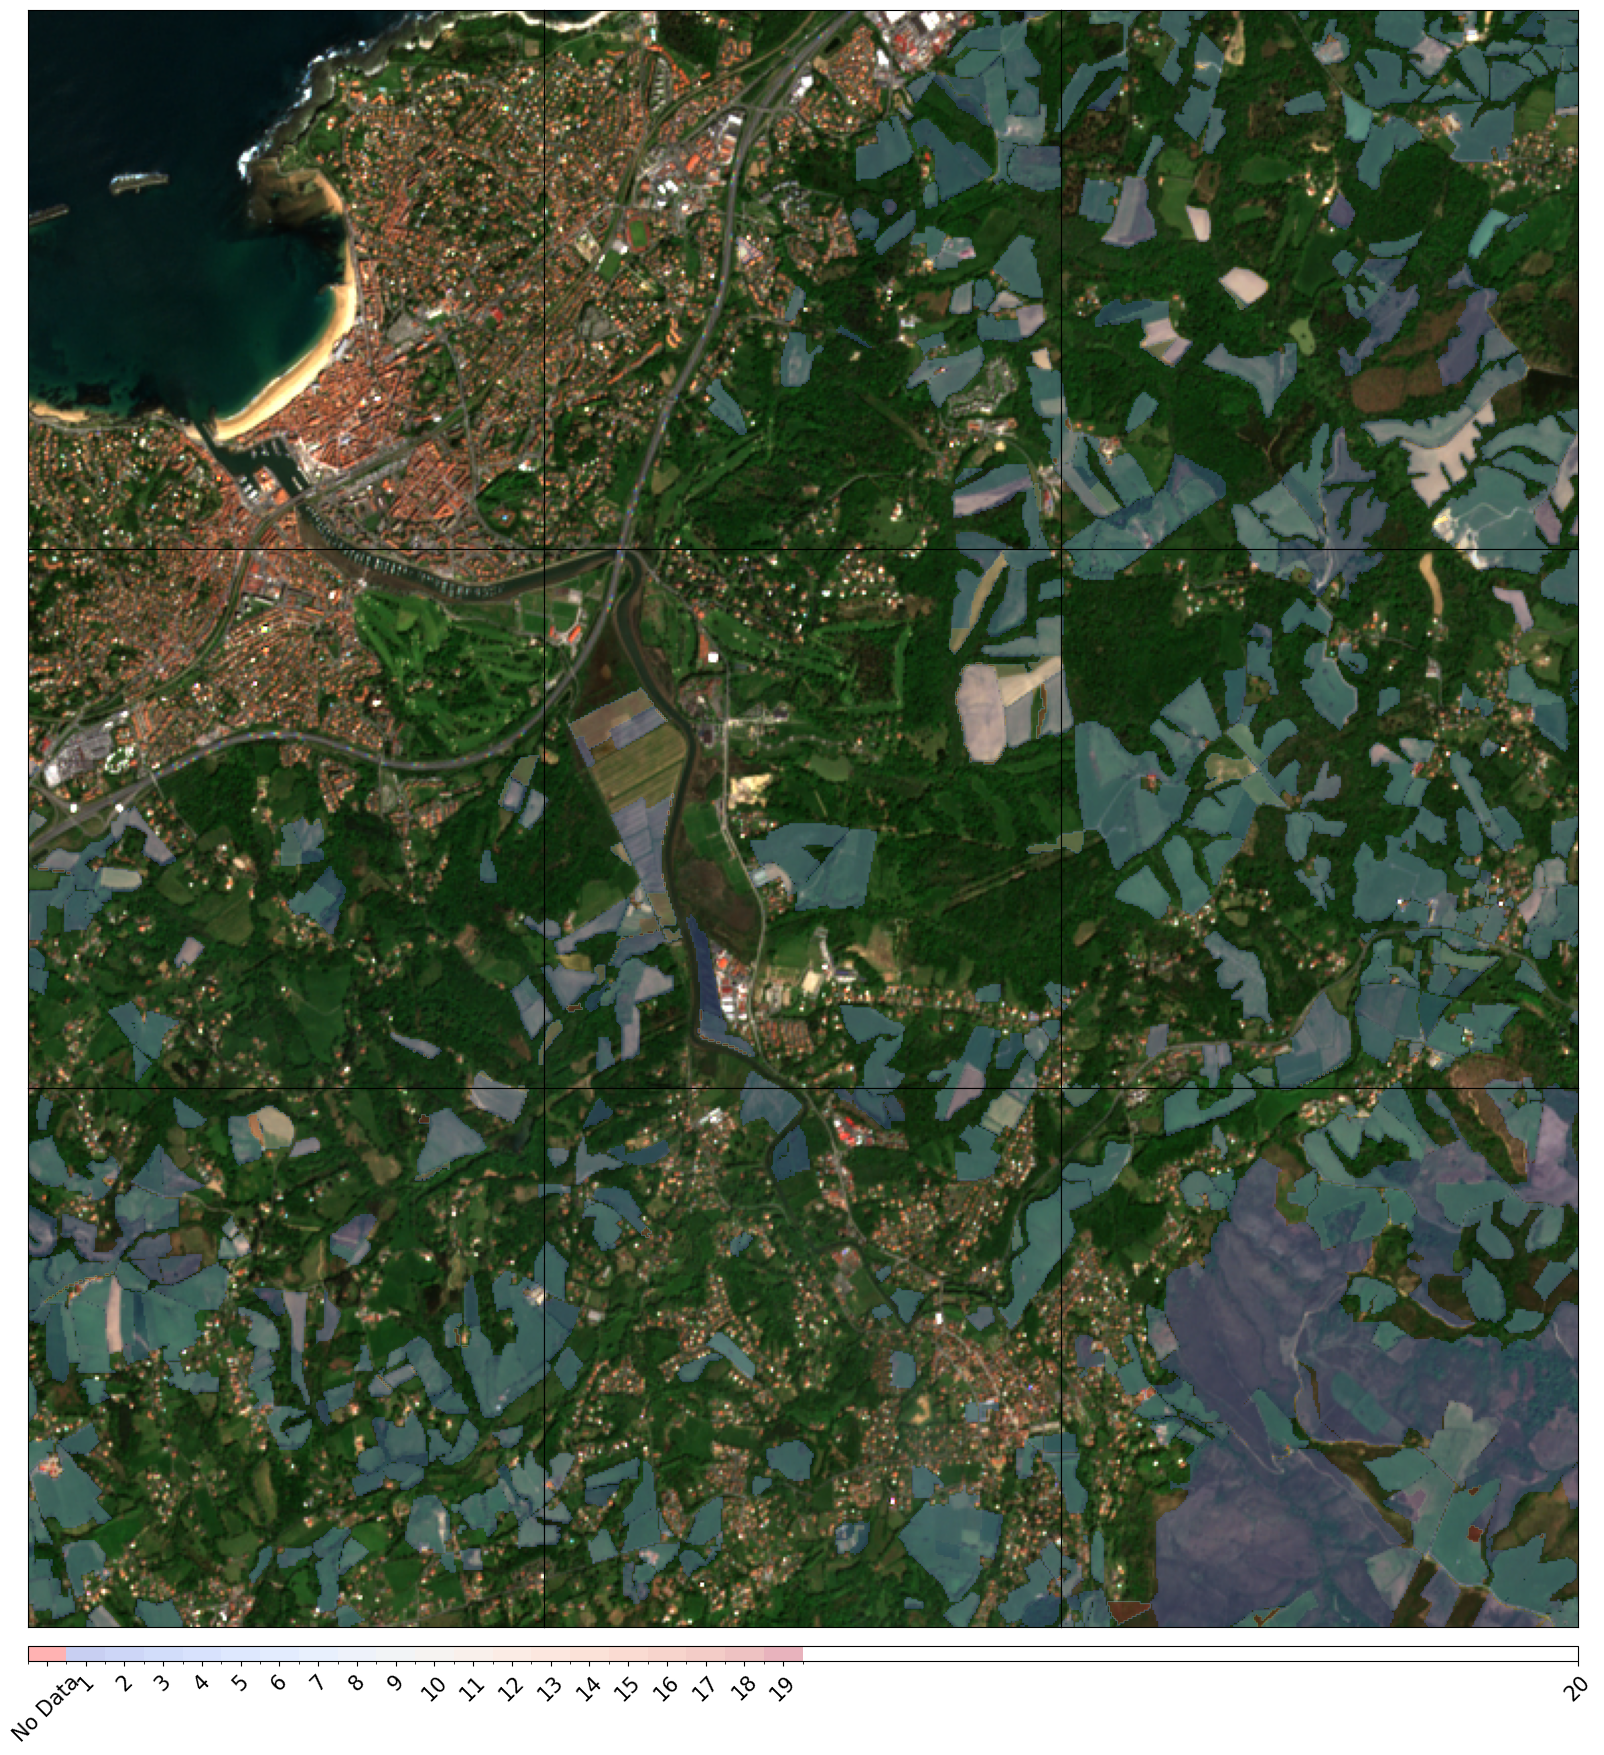

In [158]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    ax = axs[i // 3][i % 3]
    im = ax.imshow(np.moveaxis(eopatch.data_timeless["BANDS"].squeeze(), 0,2), cmap=pb_cmap, norm=pb_norm, alpha=1)
    mask = ax.imshow(eopatch.mask_timeless["pb"].squeeze(), cmap=pb_cmap, norm=pb_norm, alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(mask, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([grp_cultu_dict[key]['id'] for key in grp_cultu_dict.keys()])
cb.ax.set_xticklabels([grp_cultu_dict[key]['name'] for key in grp_cultu_dict.keys()], rotation=45, fontsize=15)
plt.show();

## Check SentinelHub data

In [201]:
STNEL_HUB_FOLDER = os.path.join("..", "eopatches")
eopatch_path = os.path.join(STNEL_HUB_FOLDER, f"eopatch_0")
eopatch = EOPatch.load(eopatch_path, lazy_loading=True)
eopatch

EOPatch(
  bbox=BBox(((500000.0, 5135000.0), (505000.0, 5140000.0)), crs=CRS('32633'))
  timestamps=[2019-01-01 10:07:42, ...]<length=48>
  mask_timeless={
    LULC: FeatureIONumpy(/mask_timeless/LULC.npy.gz)
    VALID_COUNT: FeatureIONumpy(/mask_timeless/VALID_COUNT.npy.gz)
  }
  data={
    BANDS: FeatureIONumpy(/data/BANDS.npy.gz)
    CLP: FeatureIONumpy(/data/CLP.npy.gz)
    NDBI: FeatureIONumpy(/data/NDBI.npy.gz)
    NDVI: FeatureIONumpy(/data/NDVI.npy.gz)
    NDWI: FeatureIONumpy(/data/NDWI.npy.gz)
  }
  mask={
    CLM: FeatureIONumpy(/mask/CLM.npy.gz)
    IS_DATA: FeatureIONumpy(/mask/IS_DATA.npy.gz)
    IS_VALID: FeatureIONumpy(/mask/IS_VALID.npy.gz)
  }
  vector_timeless={
    LULC_REFERENCE: FeatureIOGeoDf(/vector_timeless/LULC_REFERENCE.gpkg.gz)
  }
)

In [205]:
eopatch.data['BANDS'].shape

(48, 500, 500, 6)

In [212]:
ncols=5
nrows=10
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 25))
for i in range(ncols*nrows):
    row_num = i//ncols
    col_num = i%nrows
    axs[row_num][0].imshow(eopatch.data["BANDS"][row_num][:,:,0:3].squeeze(), alpha=1)
    axs[row_num][1].imshow(eopatch.data["BANDS"][row_num][:,:,3:].squeeze(), alpha=1)
    axs[row_num][2].imshow(eopatch.mask["CLM"][row_num][:,:,0].squeeze(), alpha=1)  
    axs[row_num][3].imshow(eopatch.mask["IS_DATA"][row_num][:,:,0].squeeze(), alpha=1)
    axs[row_num][4].imshow(eopatch.mask["IS_VALID"][row_num][:,:,0].squeeze(), alpha=1)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0524..1.1541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0098..1.2707].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0524..1.1541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0098..1.2707].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0524..1.1541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0098..1.2707].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0524..1.1541].
Clipping input data to the valid r

In [173]:
fig, axs = plt.subplots(ncols=3,nrows=6, figsize=(20, 25))
for i in range(18):
    ax = axs[i // 6][i % 3]
    ax.imshow(eopatch.data["BANDS"][i % 3][:,:,i // 6].squeeze(), cmap=pb_cmap, norm=pb_norm, alpha=1)

  0%|          | 0/9 [00:00<?, ?it/s]

KeyError: 'BANDS'

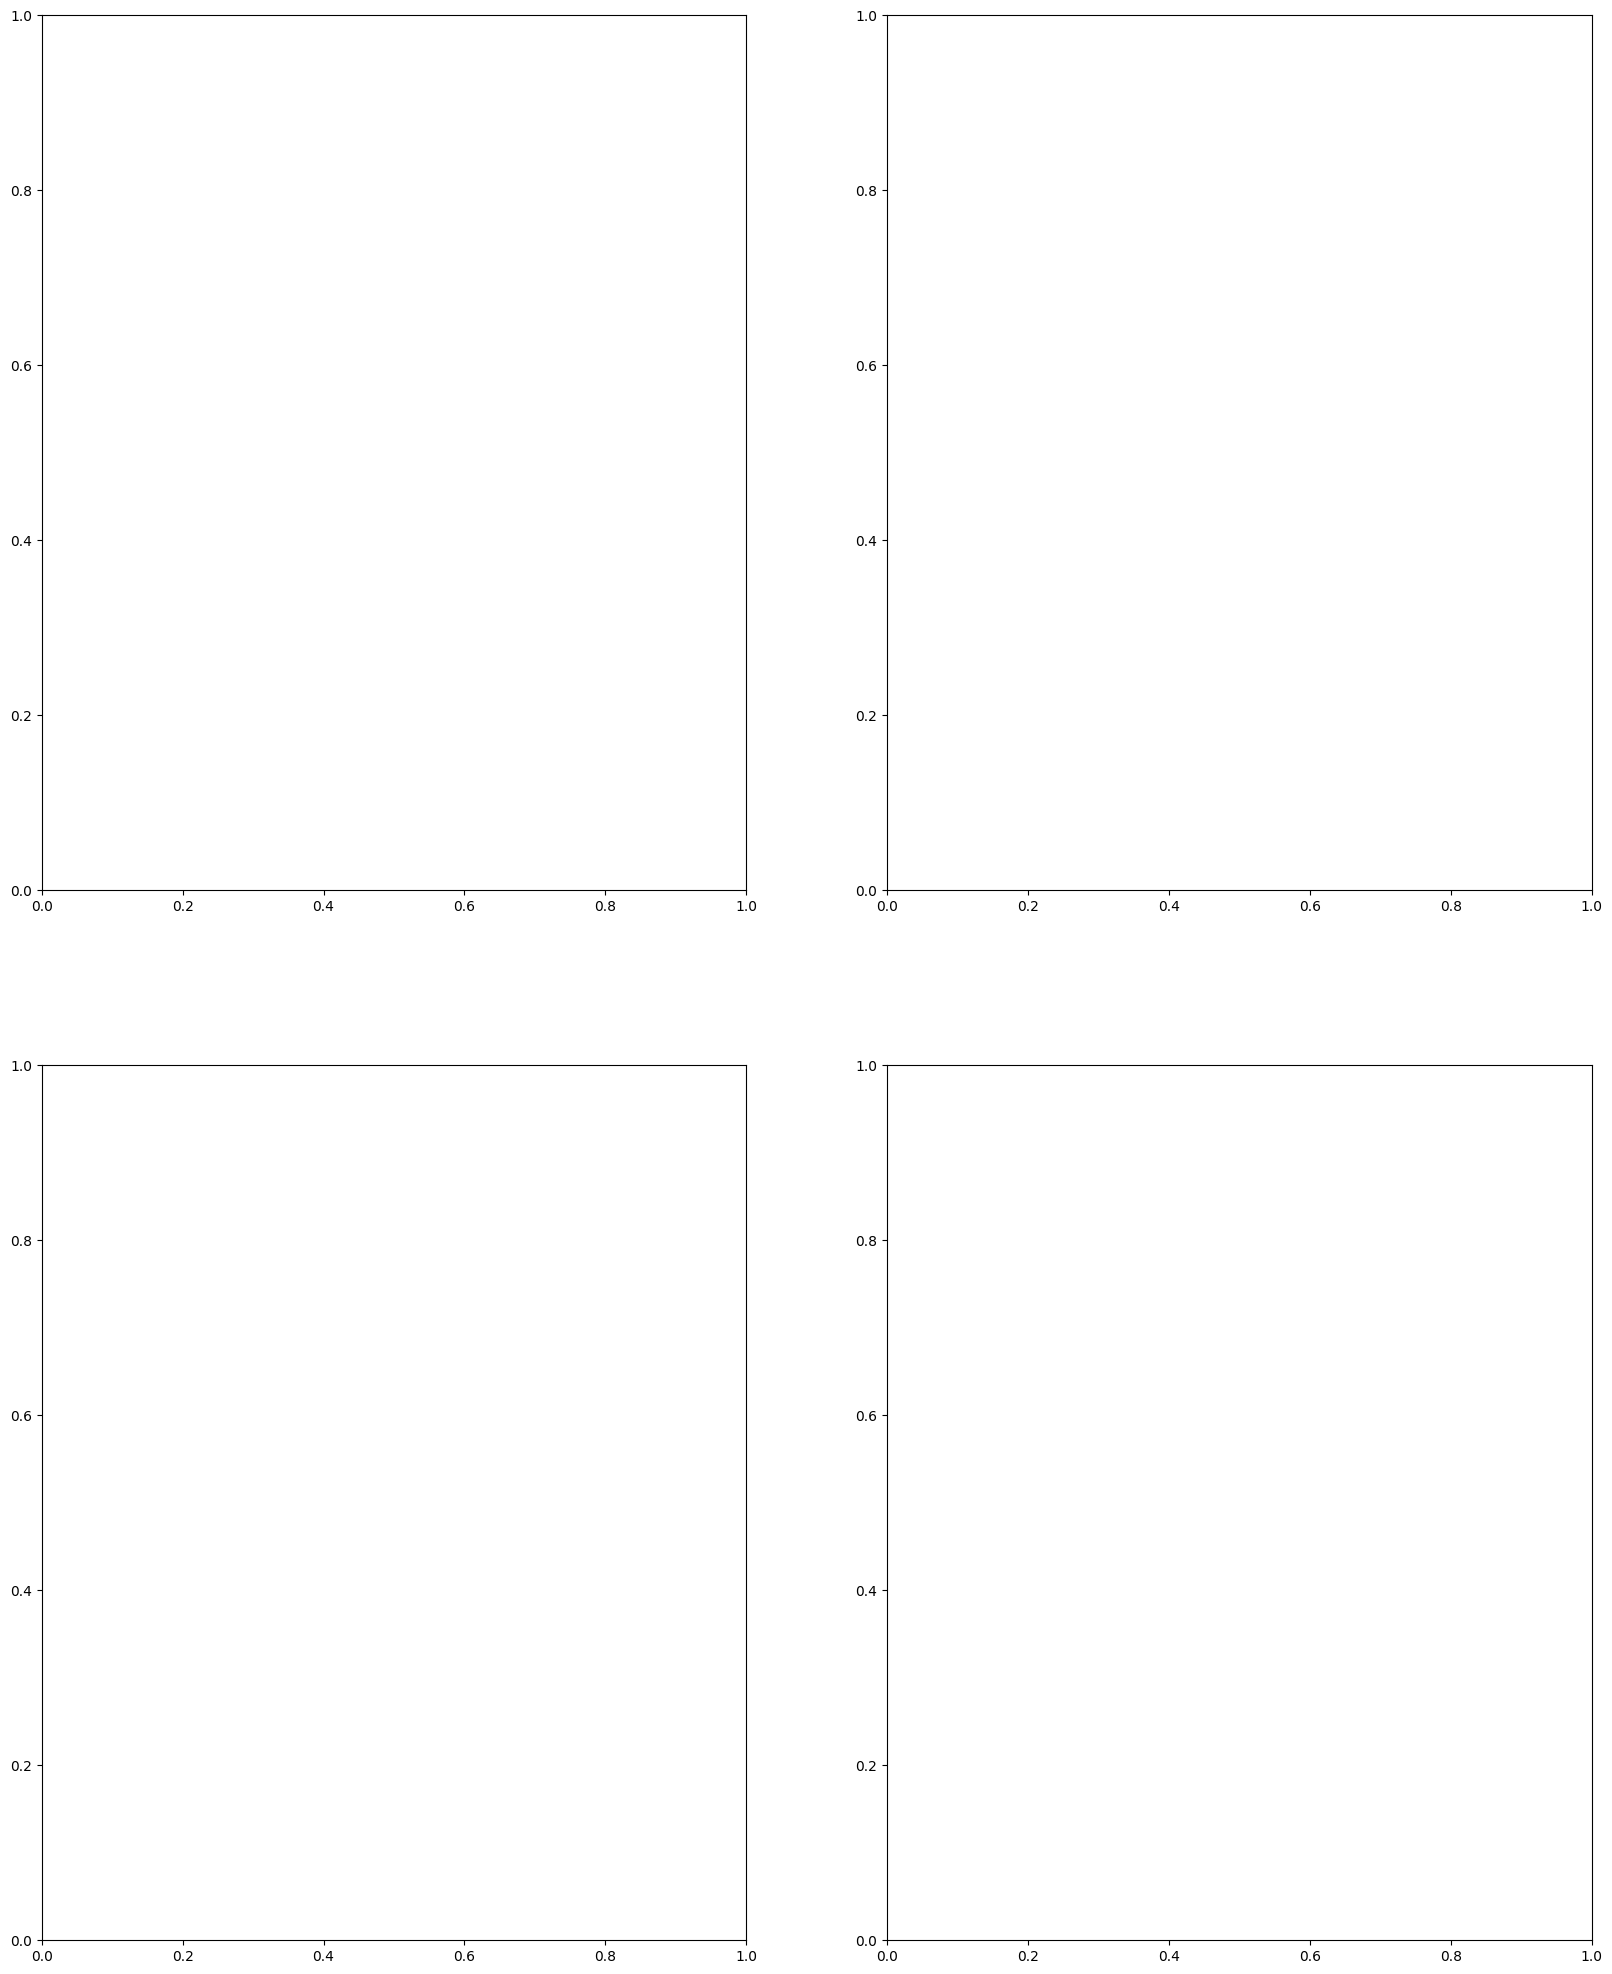

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 25))

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(STNEL_HUB_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    ax = axs[i // 6][i % 3]
    im = ax.imshow(np.moveaxis(eopatch.data["BANDS"].squeeze(), 0,2), cmap=pb_cmap, norm=pb_norm, alpha=1)
    mask = ax.imshow(eopatch.mask_timeless["pb"].squeeze(), cmap=pb_cmap, norm=pb_norm, alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(mask, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([grp_cultu_dict[key]['id'] for key in grp_cultu_dict.keys()])
cb.ax.set_xticklabels([grp_cultu_dict[key]['name'] for key in grp_cultu_dict.keys()], rotation=45, fontsize=15)
plt.show();

# EOTasks definition 

In [29]:
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    max_threads=5,
)

NameError: name 'band_names' is not defined

In [ ]:
class SentinelHubValidDataTask(EOTask):
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """

    def __init__(self, output_feature):
        self.output_feature = output_feature

    def execute(self, eopatch):
        eopatch[self.output_feature] = eopatch.mask["IS_DATA"].astype(bool) & (~eopatch.mask["CLM"].astype(bool))
        return eopatch


class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """

    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[FeatureType.MASK_TIMELESS, self.name] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch

In [ ]:
# BAND DATA
# Add a request for S2 bands.
# Here we also do a simple filter of cloudy scenes (on tile level).
# The s2cloudless masks and probabilities are requested via additional data.
band_names = ["B02", "B03", "B04", "B08", "B11", "B12"]
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    max_threads=5,
)


# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDVI"), [band_names.index("B08"), band_names.index("B04")]
)
ndwi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDWI"), [band_names.index("B03"), band_names.index("B08")]
)
ndbi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDBI"), [band_names.index("B11"), band_names.index("B08")]
)


# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = SentinelHubValidDataTask((FeatureType.MASK, "IS_VALID"))

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask("IS_VALID", "VALID_COUNT")